# fully-connected neural network

In [230]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn

In [231]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## dataset

In [ ]:
# indir = '/home/yuan/results/epitope/seq_vector_1d'
# infile = os.path.join(indir, 'epitopes_15_shrink_expand.txt')
# df = pd.read_csv(infile, sep='\t', header=None, index_col=None)
# df.head()

In [246]:
infile = '/home/yuan/results/epitope/epi_comp_vector.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# df = df.iloc[:8_000_000,:]
# shuffle rows
df = df.sample(frac=1)
df['label'] = df['label'].map({'epitope':1, 'other': 0})
df.head()

,hydrophobicity_ph7,hydrophobicity,polarity,polarizability,ven_der_waals_volume,A,R,N,D,C,...,K,M,F,P,S,T,W,Y,V,label
1177553,3.733,0.637,9.660,0.154,3.468,0.000,0.067,0.067,0.067,0.0,...,0.067,0.067,0.0,0.000,0.133,0.000,0.0,0.067,0.133,1
130189,38.000,0.894,7.260,0.096,2.015,0.200,0.000,0.000,0.000,0.0,...,0.000,0.100,0.0,0.100,0.000,0.000,0.0,0.000,0.100,1
756465,37.667,0.767,7.967,0.148,3.167,0.267,0.133,0.067,0.000,0.0,...,0.000,0.067,0.0,0.000,0.067,0.067,0.0,0.000,0.067,1
3193418,2.133,0.731,9.453,0.138,3.074,0.200,0.067,0.000,0.000,0.0,...,0.267,0.000,0.0,0.067,0.133,0.133,0.0,0.000,0.067,0
2543128,25.889,0.681,8.333,0.159,3.423,0.000,0.111,0.000,0.000,0.0,...,0.000,0.000,0.0,0.000,0.000,0.111,0.0,0.111,0.111,0


In [247]:
X = np.array(df.iloc[:,:-1], dtype=np.float16)
y = np.array(df.iloc[:,-1], dtype=np.float16)
print(X.shape, X.dtype, y.shape, y.dtype)

(3458238, 25) float16 (3458238,) float16


In [248]:
X = np.array(df.iloc[:100_000,:-1], dtype=np.float16)
y = np.array(df.iloc[:100_000,-1], dtype=np.float16)
print(X.shape, X.dtype, y.shape, y.dtype)

(100000, 25) float16 (100000,) float16


In [249]:
from collections import Counter
Counter(y)

Counter({1.0: 53968, 0.0: 46032})

In [250]:
# normalization X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_X = scaler.fit_transform(X)
norm_X[:2,]

array([[-1.003   , -1.068   ,  1.328   ,  0.05557 ,  0.2203  , -0.8413  ,
         0.1831  ,  0.4624  ,  0.2455  , -0.3955  ,  0.3413  ,  1.493   ,
         0.003752, -0.4973  , -0.7173  , -1.0205  ,  0.1063  ,  1.098   ,
        -0.64    , -0.711   ,  0.631   , -0.7686  , -0.3464  ,  0.6733  ,
         0.869   ],
       [ 1.016   ,  0.005657, -1.494   , -1.9375  , -2.193   ,  1.397   ,
        -0.7373  , -0.646   , -0.735   , -0.3955  , -0.661   , -0.7905  ,
         2.76    , -0.4973  , -0.7173  ,  1.075   , -0.752   ,  1.86    ,
        -0.64    ,  0.508   , -0.8623  , -0.7686  , -0.3464  , -0.562   ,
         0.4395  ]], dtype=float16)

In [251]:
#split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(norm_X, y, train_size=0.8, shuffle=True, random_state=2)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.7, shuffle=True, random_state=2)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(56000, 25) (56000,)
(24000, 25) (24000,)
(20000, 25) (20000,)


## train model

In [267]:
from tensorflow.keras.layers import Input, Dense, Dropout

# input features
num_features = int(X.shape[-1])
# outccome is binary
model = tf.keras.Sequential([
    Input(shape=(num_features,)),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(4096, activation='relu'),
    Dropout(0.2),
    Dense(4096, activation='relu'),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 1024)           │        26,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 96)             │        98,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,300,161 (96.51 MB)

 Trainable params: 25,300,161 (96.51 MB)

 Non-trainable params: 0 (0.00 B)

In [268]:
# loss_fn = tf.keras.losses.sparse_categorical_crossentropy
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy', 'precision', 'recall', 'auc', 'mse'])

epochs = 50
history= model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, verbose=False)

res = pd.DataFrame(history.history)
print(res.head(3))
print(res.tail(3))

2025-01-08 17:05:33.932797: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 16 bytes spill stores, 16 bytes spill loads

2025-01-08 17:05:34.006601: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 132 bytes spill stores, 132 bytes spill loads



   accuracy       auc      loss       mse  precision    recall  val_accuracy  \
0  0.619625  0.646332  0.659776  0.232974   0.623750  0.747441      0.627875   
1  0.634821  0.673942  0.644376  0.225967   0.631888  0.777789      0.640958   
2  0.640196  0.683721  0.638946  0.223448   0.637441  0.775973      0.643625   

    val_auc  val_loss   val_mse  val_precision  val_recall  
0  0.672208  0.643280  0.225911       0.639785    0.702010  
1  0.686701  0.637814  0.223555       0.634489    0.781107  
2  0.690680  0.635097  0.222004       0.636473    0.783746  
    accuracy       auc      loss       mse  precision    recall  val_accuracy  \
47  0.797000  0.882122  0.428746  0.139140   0.804025  0.825903      0.632292   
48  0.800964  0.884206  0.427752  0.137740   0.802326  0.838518      0.630250   
49  0.801732  0.887246  0.421465  0.135868   0.804458  0.836735      0.632000   

     val_auc  val_loss   val_mse  val_precision  val_recall  
47  0.676244  0.799548  0.247185       0.657948 

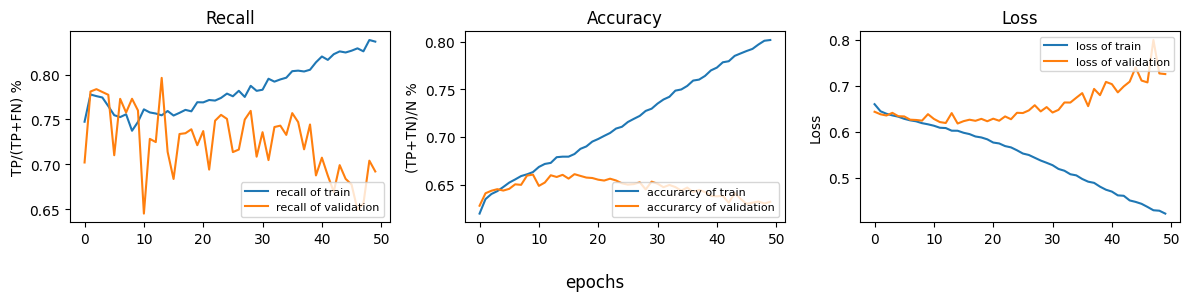

In [269]:
fig, axes = plt.subplots(1, 3, figsize=(12,3), layout='tight')
x = range(epochs)
fig.supxlabel('epochs')

i=0
axes[i].plot(x, history.history['recall'], label='recall of train')
axes[i].plot(x, history.history['val_recall'], label='recall of validation')
axes[i].set_ylabel('TP/(TP+FN) %')
axes[i].set_title('Recall')
axes[i].legend(loc='lower right', fontsize=8)

i=1
axes[i].plot(x, history.history['accuracy'], label='accurarcy of train')
axes[i].plot(x, history.history['val_accuracy'], label='accurarcy of validation')
axes[i].set_ylabel('(TP+TN)/N %')
axes[i].set_title('Accuracy')
axes[i].legend(loc='lower right', fontsize=8)

i=2
axes[i].plot(x, history.history['loss'], label='loss of train')
axes[i].plot(x, history.history['val_loss'], label='loss of validation')
axes[i].set_ylabel('Loss')
axes[i].set_title('Loss')
axes[i].legend(loc='upper right', fontsize=8)

In [270]:
eval_res = model.evaluate(X_test, y_test, return_dict=True)
print(eval_res)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - accuracy: 0.6381 - auc: 0.6776 - loss: 0.7279 - mse: 0.2375 - precision: 0.6528 - recall: 0.6930
{'accuracy': 0.6305500268936157, 'auc': 0.6715821027755737, 'loss': 0.7359755635261536, 'mse': 0.23982304334640503, 'precision': 0.6485381126403809, 'recall': 0.6899009346961975}


In [271]:
pred_test = model.predict(X_test)
pred_test[:3]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step


array([[0.53936386],
       [0.74493325],
       [0.23721424]], dtype=float32)

Text(0.5, 1.0, 'Prediction of False outcome 9197')

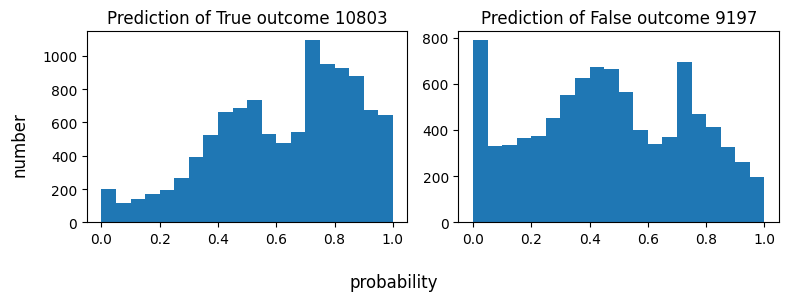

In [272]:

t = pred_test[y_test==1]
f = pred_test[y_test==0]
fig, ax = plt.subplots(1, 2, figsize=(8,3), layout='tight')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, label='True', bins=20)
ax[0].set_title(f'Prediction of True outcome {len(t)}')
ax[1].hist(f, label='False', bins=20)
ax[1].set_title(f'Prediction of False outcome {len(f)}')

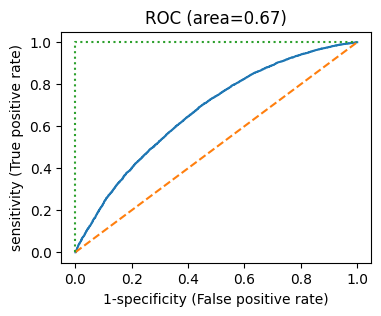

In [276]:
# ROC curve only for binary classfication
from sklearn.metrics import roc_curve, auc
# FPR, false positive rate, 1- specificity, typ I error
# TPR, true positive rate, sensitivity, power
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(fpr, tpr)
ax.set_xlabel('1-specificity (False positive rate)')
ax.set_ylabel('sensitivity (True positive rate)')
plt.title(f'ROC (area={roc_auc:.2f})')
ax.plot([0,1], [0,1], '--')
ax.plot([0,0,1], [0,1,1], ':')